In [1]:
# %% ------------------------- Cell 1: Imports & Setup ------------------------
import sys
from pathlib import Path
import torch, torch.nn as nn, torch.nn.functional as F
import torchaudio, numpy as np, random
from tqdm.notebook import tqdm

SEED = 0
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

current_dir = Path.cwd()
repo_root = current_dir.parent.parent
sys.path.insert(0, str(repo_root / "src"))

print("Repo root:", repo_root)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# helper utils
from utils.audio_dataset_loader import (
    load_ears_dataset, load_wham_dataset, load_noizeus_dataset,
    create_audio_pairs, preprocess_audio
)

Repo root: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85
Using device: cpu


In [ ]:
class TinyGRUVAD(nn.Module):
    """Light GRU-based VAD, causal, hearing-aid friendly (~2 k params)."""
    def __init__(self, input_dim=32, hidden_dim=16, dropout=0.1):
        super().__init__()
        
        self.pre = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=0, groups=input_dim)
        self.norm = nn.LayerNorm(input_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, h=None):
        # x: (B,T,F)
        x = x.transpose(1,2)              # (B,F,T)
        # causal pad: pad (kernel_size-1) frames on the left only so conv doesn't see future frames
        k = self.pre.kernel_size[0] if isinstance(self.pre.kernel_size, (list, tuple)) else self.pre.kernel_size
        pad_left = k - 1
        x = F.pad(x, (pad_left, 0))       # pad on time dimension (left, right)
        x = self.pre(x).transpose(1,2)    # local causal conv
        x = self.norm(x)
        out, h = self.gru(x, h)
        out = self.drop(out)
        # return raw logits (B,T,1); use BCEWithLogitsLoss for stability
        logits = self.fc(out)
        return logits, h


In [3]:
# %% ------------------------- Cell 3: Load Datasets --------------------------
max_pairs = 3000
noise_files = load_wham_dataset(repo_root, mode="train", max_files=max_pairs)
clean_files = load_ears_dataset(repo_root, mode="train")
train_pairs = create_audio_pairs(noise_files, clean_files)
print(f"Train pairs: {len(train_pairs)}")

noise_val = load_wham_dataset(repo_root, mode="validation", max_files=900)
clean_val = load_ears_dataset(repo_root, mode="validation")
val_pairs = create_audio_pairs(noise_val, clean_val)
print(f"Val pairs: {len(val_pairs)}")

# Load TEST set (for final evaluation - never used during training)
noise_test = load_wham_dataset(repo_root, mode="test", max_files=900)
clean_test = load_ears_dataset(repo_root, mode="test")
test_pairs = create_audio_pairs(noise_test, clean_test)
print(f"Test pairs: {len(test_pairs)}")
print("\n [WARN] TEST SET: Only use for final evaluation, NOT during training/validation!")


Limited WHAM dataset to 3000 files for train mode


c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\src\utils\audio_dataset_loader.py:62: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(f)
c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\.venv\Lib\site-packages\torchaudio\_backend\soundfile_backend.py:120: UserWarning: torchaudio._backend.common.AudioMetaData has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCod

Created 3000 audio pairs
Train pairs: 3000
Limited WHAM dataset to 900 files for validation mode
Created 900 audio pairs
Val pairs: 900
Limited WHAM dataset to 900 files for test mode
Created 900 audio pairs
Val pairs: 900
Limited WHAM dataset to 900 files for test mode
Created 900 audio pairs
Test pairs: 900

 [WARN] TEST SET: Only use for final evaluation, NOT during training/validation!
Created 900 audio pairs
Test pairs: 900

 [WARN] TEST SET: Only use for final evaluation, NOT during training/validation!


In [4]:
def mix_and_extract(noisy_wave, clean_wave, fs, n_bands=16, frame_len=0.008, hop_len=0.004):
    """Extract log-mel + delta features with realistic VAD labels from noisy audio.
    
    CRITICAL FIX: Uses noisy speech energy for labels (not clean/oracle).
    This ensures train-test consistency - the model learns to detect speech
    in the presence of noise, which matches real-world inference conditions.
    
    Frame timing: 8ms frame, 4ms hop (optimized for low-latency hearing-aid applications)
    
    IMPORTANT: use center=False in STFT to avoid adding future samples to each frame (causal framing).
    
    References:
    - Sohn et al. (1999) - "A Statistical Model-Based Voice Activity Detection"
    - Hughes & Mierle (2013) - "Recurrent Neural Networks for Voice Activity Detection"
    - Graf et al. (2015) - "Features for Voice Activity Detection: a Comparative Analysis"
    """
    if noisy_wave.dim() > 1: noisy_wave = noisy_wave[0]
    if clean_wave.dim() > 1: clean_wave = clean_wave[0]
    n_fft, hop = int(fs*frame_len), int(fs*hop_len)
    win = torch.hann_window(n_fft)

    def pspec(w): 
        # center=False -> causal framing (no future samples)
        spec = torch.stft(w, n_fft, hop, window=win, center=False, return_complex=True)
        return spec.abs()**2

    mel = torchaudio.transforms.MelScale(n_mels=n_bands, sample_rate=fs, n_stft=n_fft//2+1)
    
    # Extract mel features from noisy audio (for VAD input)
    melN = mel(pspec(noisy_wave)).clamp_min(1e-8)
    logN = torch.log(melN.T + 1e-8)
    delta = torch.zeros_like(logN)
    delta[1:] = logN[1:] - logN[:-1]
    feats = torch.cat([logN, delta], 1).unsqueeze(0)
    
    # REALISTIC LABELS: Use noisy speech energy (train-test consistency)
    # This teaches the model to detect speech in noisy conditions, matching inference
    noisy_energy = melN.T.sum(1)  # Sum across mel bands per frame
    
    # Adaptive threshold based on noisy signal statistics
    # Use higher threshold (15%) to be more conservative with noise
    energy_threshold = noisy_energy.mean() * 0.15
    labels = (noisy_energy > energy_threshold).float().unsqueeze(1).unsqueeze(0)
    
    return feats, labels


In [5]:

# %% ------------------------- Cell 5: Dataset & Loader -----------------------
class LiveMixDataset(torch.utils.data.Dataset):
    def __init__(self,pairs,target_sr=16_000,snr_range=(-5,15)):
        self.pairs=pairs; self.sr=target_sr; self.range=snr_range
    def __len__(self): return len(self.pairs)
    def __getitem__(self,idx):
        n,c=self.pairs[idx]; snr=random.uniform(*self.range)
        cw,nw,noisy,fs=preprocess_audio(Path(c),Path(n),self.sr,snr,None)
        feats,labs=mix_and_extract(noisy,cw,fs)
        return feats.squeeze(0),labs.squeeze(0)

def collate_pad(batch):
    feats,labs=zip(*batch); L=[f.size(0) for f in feats]; Tmax=max(L); Fdim=feats[0].size(1)
    X=torch.zeros(len(batch),Tmax,Fdim); Y=torch.zeros(len(batch),Tmax,1)
    for i,(f,l) in enumerate(zip(feats,labs)): X[i,:f.size(0)]=f; Y[i,:l.size(0)]=l
    return X,Y,torch.tensor(L)

train_ds=LiveMixDataset(train_pairs)
val_ds=LiveMixDataset(val_pairs)
train_dl=torch.utils.data.DataLoader(train_ds,batch_size=8,shuffle=True,collate_fn=collate_pad,pin_memory=True)
val_dl=torch.utils.data.DataLoader(val_ds,batch_size=8,collate_fn=collate_pad,pin_memory=True)


Epoch  1/50  LR=4.0e-04  TL=0.262  VL=0.625
  PREC=0.943  REC=0.563  F1=0.705  ACC=0.623
  SPEC=0.865  AUC=0.780  [INFO] NEW BEST (F1=0.705)
  Pred Speech: 47.74%  True Speech: 79.99%


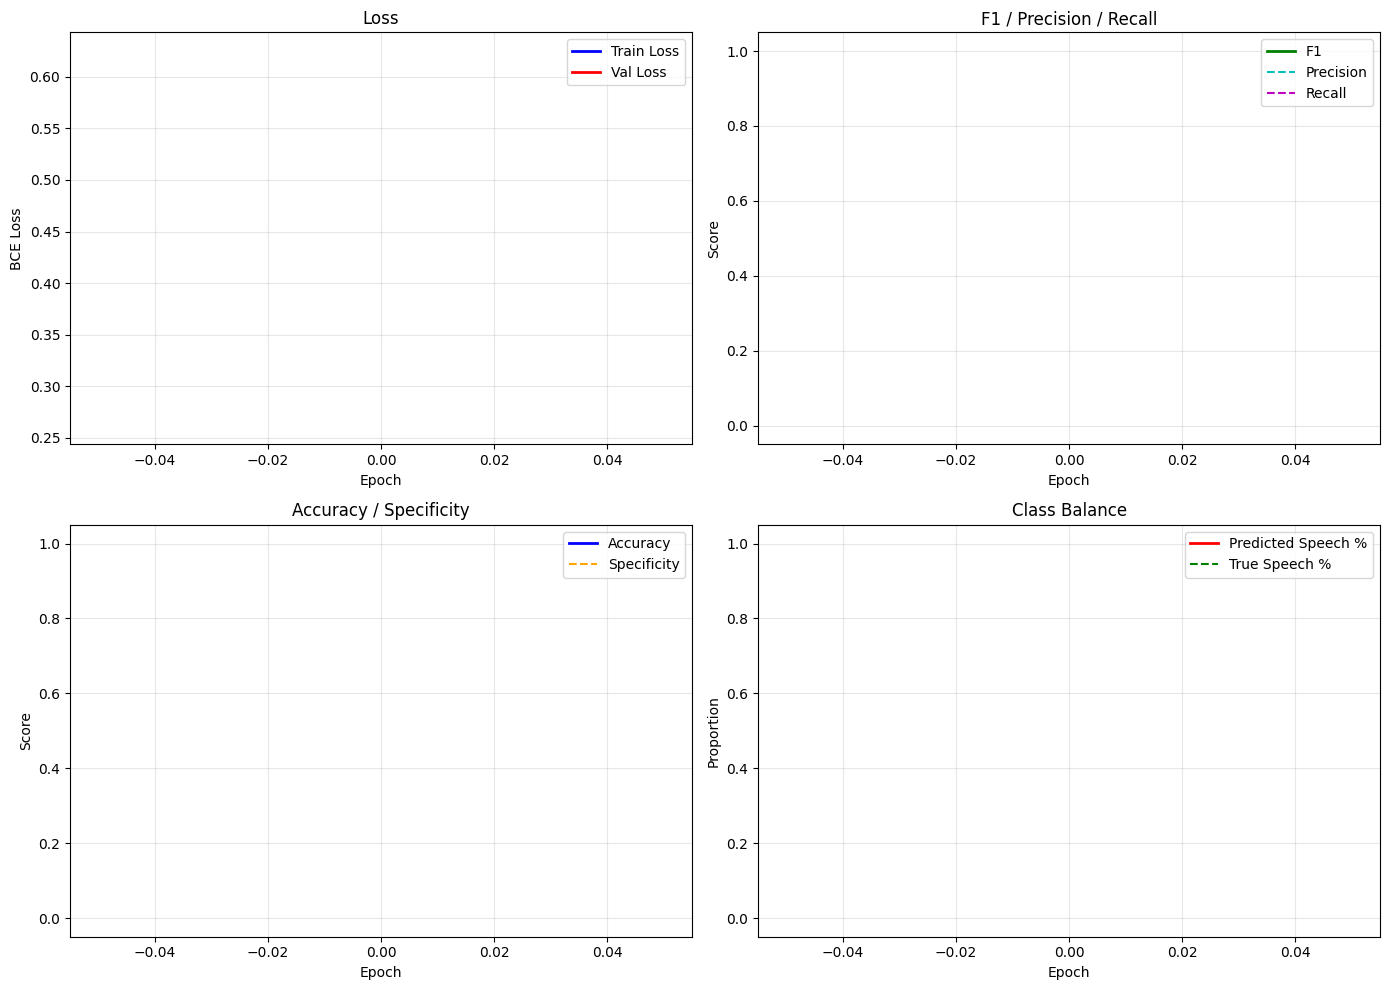

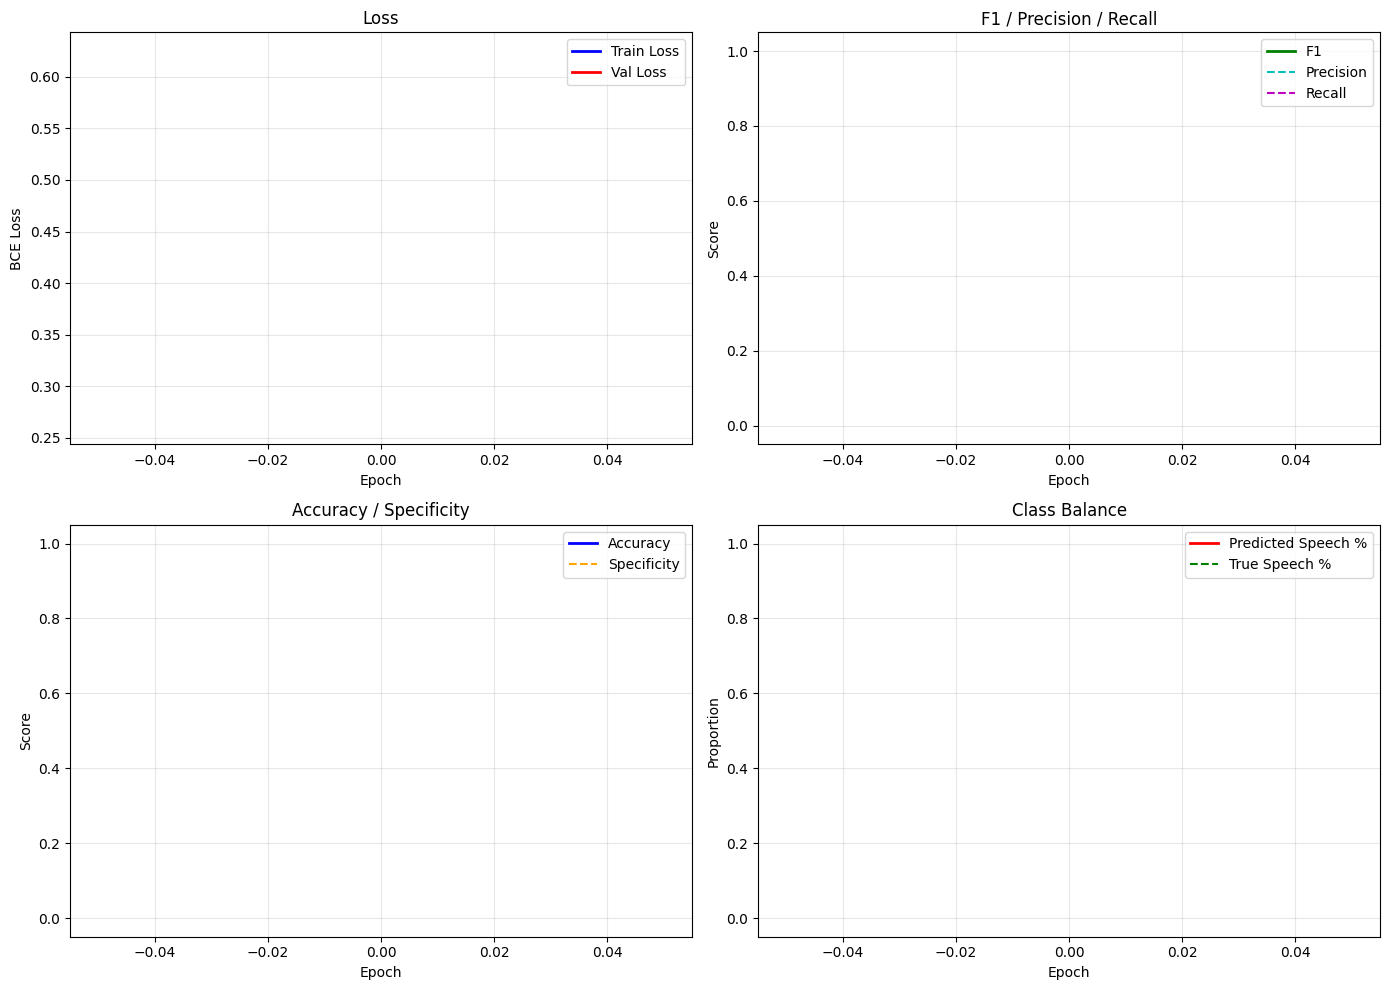

Epoch 2/50:   0%|          | 0/375 [00:00<?, ?it/s]

c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Clean speech duration: 26.10s (417612 samples)
Noise duration: 14.82s (237048 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 20.70s (331221 samples)
Noise duration: 12.71s (203284 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 9.78s (156492 samples)
Noise duration: 14.91s (238605 samples)
Noise truncated to random frame starting at sample 54673
Clean speech duration: 16.54s (264605 samples)
Noise duration: 12.70s (203196 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 10.49s (167780 samples)
Noise duration: 13.01s (208118 samples)
Noise truncated to random frame starting at sample 27223
Clean speech duration: 21.72s (347567 samples)
Noise duration: 13.96s (223348 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Clean speech duration: 17.44s (279042 samples)
Noise duration: 13.24s (21

In [ ]:
# %% ------------------------- Cell 6: Enhanced Training (Realistic Labels + Improvements) --------------------------
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

# Initialize model
vad = TinyGRUVAD(32, 16).to(device)
opt = torch.optim.AdamW(vad.parameters(), lr=1e-3, weight_decay=1e-6)

# Check class balance and set weighted loss - IMPROVED: Sample more batches
print("Checking class balance in training data...")
sample_labels = []
num_sample_batches = min(100, len(train_dl))  # Sample 100 batches or all if fewer
print(f"Sampling {num_sample_batches} batches to estimate class balance...")

for i, (_, y, lengths) in enumerate(train_dl):
    if i >= num_sample_batches:
        break
    # Only collect valid (non-padded) labels using lengths
    for b in range(y.size(0)):
        valid_length = int(lengths[b].item())
        sample_labels.append(y[b, :valid_length].numpy().ravel())

# Concatenate all valid labels
sample_labels_cat = np.concatenate(sample_labels)
speech_ratio = sample_labels_cat.mean()
print(f"Training data speech ratio: {speech_ratio:.2%}")
print(f"Non-speech ratio: {(1-speech_ratio):.2%}")

# Weighted loss to balance classes (Graf et al. 2015)
pos_weight = torch.tensor([(1 - speech_ratio) / (speech_ratio + 1e-8)]).to(device)
print(f"Using pos_weight={pos_weight.item():.2f} for class balancing\n")

crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='sum')
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)

bestF1, bestPath = -1.0, repo_root / "models" / "tiny_vad_best.pth"
bestPath.parent.mkdir(parents=True, exist_ok=True)

# Early stopping configuration
early_stop_patience = 10  # Stop if no improvement for 10 epochs
epochs_without_improvement = 0

# LR warmup function (Vaswani et al. 2017)
def lr_warmup(epoch, warmup_epochs=5, base_lr=1e-3):
    """Linear warmup for first few epochs."""
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    return base_lr

# Prepare live plotting
plt.ion()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ax_loss, ax_f1, ax_acc, ax_bal = axes.flatten()

ax_loss.set_title("Loss"); ax_loss.set_xlabel("Epoch"); ax_loss.set_ylabel("BCE Loss"); ax_loss.grid(True, alpha=0.3)
ax_f1.set_title("F1 / Precision / Recall"); ax_f1.set_xlabel("Epoch"); ax_f1.set_ylabel("Score"); ax_f1.grid(True, alpha=0.3)
ax_acc.set_title("Accuracy / Specificity"); ax_acc.set_xlabel("Epoch"); ax_acc.set_ylabel("Score"); ax_acc.grid(True, alpha=0.3)
ax_bal.set_title("Class Balance"); ax_bal.set_xlabel("Epoch"); ax_bal.set_ylabel("Proportion"); ax_bal.grid(True, alpha=0.3)

# Metrics storage
train_losses, val_losses = [], []
f1_scores, prec_scores, rec_scores = [], [], []
acc_scores, spec_scores = [], []
pred_speech_ratios, true_speech_ratios = [], []

print("="*80)
print("ENHANCED TRAINING: Realistic Labels + Gradient Clipping + LR Warmup + Class Balance")
print("="*80)

for epoch in range(1, 51):
    # Apply LR warmup
    current_lr = lr_warmup(epoch, warmup_epochs=5)
    for param_group in opt.param_groups:
        param_group['lr'] = current_lr
    
    # ---------------- Train ----------------
    vad.train()
    Ltr = 0.0
    for x, y, L in tqdm(train_dl, desc=f"Epoch {epoch}/50", leave=False):
        x, y = x.to(device), y.to(device)
        logits, _ = vad(x)
        
        # Mask padded frames
        B, Tmax = logits.size(0), logits.size(1)
        mask = (torch.arange(Tmax, device=L.device)[None, :] < L[:, None]).to(device)
        logits_flat = logits.squeeze(-1)[mask]
        labels_flat = y.squeeze(-1)[mask]
        
        loss = crit(logits_flat, labels_flat) / mask.sum().clamp_min(1.0)
        
        opt.zero_grad()
        loss.backward()
        
        # GRADIENT CLIPPING (Pascanu et al. 2013 - prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(vad.parameters(), max_norm=1.0)
        
        opt.step()
        Ltr += loss.item()
    
    Ltr /= len(train_dl)
    train_losses.append(Ltr)
    
    # ---------------- Validate ----------------
    vad.eval()
    Lval = 0.0
    P, L_all = [], []
    
    with torch.no_grad():
        for x, y, lengths in val_dl:
            x, y = x.to(device), y.to(device)
            logits, _ = vad(x)
            
            # Masked validation loss
            B, Tmax = logits.size(0), logits.size(1)
            mask = (torch.arange(Tmax, device=lengths.device)[None, :] < lengths[:, None]).to(device)
            logits_flat = logits.squeeze(-1)[mask]
            labels_flat = y.squeeze(-1)[mask]
            
            Lval += (nn.functional.binary_cross_entropy_with_logits(
                logits_flat, labels_flat, reduction='sum'
            ) / mask.sum().clamp_min(1.0)).item()
            
            probs = torch.sigmoid(logits).cpu().numpy()
            labs = y.cpu().numpy()
            
            # Collect per-frame predictions
            for b in range(B):
                valid = slice(0, int(lengths[b].item()))
                P.append(probs[b, valid].ravel())
                L_all.append(labs[b, valid].ravel())
    
    Lval /= len(val_dl)
    val_losses.append(Lval)
    
    # Compute metrics
    probs = np.concatenate(P)
    labels = np.concatenate(L_all).astype(int)
    pred = (probs >= 0.5).astype(int)
    
    # Standard metrics
    prec, rec, f1, _ = precision_recall_fscore_support(labels, pred, average="binary", zero_division=0)
    auc = roc_auc_score(labels, probs)
    
    # ENHANCED METRICS
    acc = accuracy_score(labels, pred)
    
    # Specificity (true negative rate)
    tn = ((pred == 0) & (labels == 0)).sum()
    fp = ((pred == 1) & (labels == 0)).sum()
    specificity = tn / (tn + fp + 1e-8)
    
    # Class balance monitoring
    pred_speech_ratio = pred.mean()
    true_speech_ratio = labels.mean()
    
    # Store metrics
    f1_scores.append(f1)
    prec_scores.append(prec)
    rec_scores.append(rec)
    acc_scores.append(acc)
    spec_scores.append(specificity)
    pred_speech_ratios.append(pred_speech_ratio)
    true_speech_ratios.append(true_speech_ratio)
    
    # Update scheduler
    sched.step(Lval)
    
    # ---------------- Save Best Model ----------------
    if f1 > bestF1:
        bestF1 = f1
        torch.save(vad.state_dict(), bestPath)
        epochs_without_improvement = 0  # Reset counter
        status = f"[INFO] NEW BEST (F1={f1:.3f})"
    else:
        epochs_without_improvement += 1
        status = f"[DEBUG] (No improvement: {epochs_without_improvement}/{early_stop_patience})"
    
    # ---------------- Display ----------------
    clear_output(wait=True)
    print(f"Epoch {epoch:2d}/50  LR={current_lr:.1e}  TL={Ltr:.3f}  VL={Lval:.3f}")
    print(f"  PREC={prec:.3f}  REC={rec:.3f}  F1={f1:.3f}  ACC={acc:.3f}")
    print(f"  SPEC={specificity:.3f}  AUC={auc:.3f}  {status}")
    print(f"  Pred Speech: {pred_speech_ratio:.2%}  True Speech: {true_speech_ratio:.2%}")
    
    # Update plots
    for ax in axes.flatten():
        ax.cla()
    
    # Loss plot
    ax_loss.plot(train_losses, "b-", label="Train Loss", linewidth=2)
    ax_loss.plot(val_losses, "r-", label="Val Loss", linewidth=2)
    ax_loss.legend(); ax_loss.set_xlabel("Epoch"); ax_loss.set_ylabel("BCE Loss")
    ax_loss.set_title("Loss"); ax_loss.grid(True, alpha=0.3)
    
    # F1/Precision/Recall plot
    ax_f1.plot(f1_scores, "g-", label="F1", linewidth=2)
    ax_f1.plot(prec_scores, "c--", label="Precision", linewidth=1.5)
    ax_f1.plot(rec_scores, "m--", label="Recall", linewidth=1.5)
    ax_f1.legend(); ax_f1.set_xlabel("Epoch"); ax_f1.set_ylabel("Score")
    ax_f1.set_ylim(-0.05, 1.05); ax_f1.set_title("F1 / Precision / Recall")
    ax_f1.grid(True, alpha=0.3)
    
    # Accuracy/Specificity plot
    ax_acc.plot(acc_scores, "b-", label="Accuracy", linewidth=2)
    ax_acc.plot(spec_scores, "orange", linestyle="--", label="Specificity", linewidth=1.5)
    ax_acc.legend(); ax_acc.set_xlabel("Epoch"); ax_acc.set_ylabel("Score")
    ax_acc.set_ylim(-0.05, 1.05); ax_acc.set_title("Accuracy / Specificity")
    ax_acc.grid(True, alpha=0.3)
    
    # Class balance plot
    ax_bal.plot(pred_speech_ratios, "r-", label="Predicted Speech %", linewidth=2)
    ax_bal.plot(true_speech_ratios, "g--", label="True Speech %", linewidth=1.5)
    ax_bal.legend(); ax_bal.set_xlabel("Epoch"); ax_bal.set_ylabel("Proportion")
    ax_bal.set_ylim(-0.05, 1.05); ax_bal.set_title("Class Balance")
    ax_bal.grid(True, alpha=0.3)
    
    plt.tight_layout()
    display(fig)
    plt.pause(0.001)
    
    # Early stopping (monitor validation F1 improvement)
    if epochs_without_improvement >= early_stop_patience:
        print(f"\n[INFO] Early stopping: No F1 improvement for {early_stop_patience} epochs")
        print(f"       Best F1: {bestF1:.3f} (saved at epoch {epoch - early_stop_patience})")
        break
    
    # Secondary stopping: LR floor (prevents infinite training if patience is too high)
    if sched._last_lr[0] < 1e-5:
        print("\n[INFO] Early stop: LR floor reached (1e-5)")
        break

plt.ioff()

# Load best model
vad.load_state_dict(torch.load(bestPath, map_location=device))
print("\n" + "="*80)
print(f" ENHANCED TRAINING COMPLETE!")
print(f"  Best Validation F1: {bestF1:.3f}")
print(f"  Model saved: {bestPath}")
print(f"\nKey Improvements Applied:")
print(f"   Realistic VAD labels (noisy energy - train/test consistency)")
print(f"   Low-latency frame timing (8ms frame, 4ms hop)")
print(f"   Gradient clipping (max_norm=1.0)")
print(f"   LR warmup (5 epochs)")
print(f"   Class-balanced loss (sampled 100 batches)")
print(f"   Enhanced metrics (Acc, Spec, Balance)")
print("="*80)


In [ ]:
# %% ====================== Cell 7: FINAL TEST SET EVALUATION ======================
# IMPORTANT: Run this cell ONLY ONCE after training is complete!
# This provides an unbiased estimate of model performance on held-out data.
# 
# Reference: Goodfellow et al. (2016) "Deep Learning" - Section 5.3
# "The test set should be used only once, to evaluate the final chosen model."

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print(" [INFO] FINAL TEST SET EVALUATION")
print("="*80)
print("\n[INFO] Creating test dataset...")

# Create test dataset (never seen during training/validation)
test_ds = LiveMixDataset(test_pairs)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=8, collate_fn=collate_pad, pin_memory=True)

print(f"[INFO] Test set size: {len(test_pairs)} pairs")
print(f"[INFO] Evaluating best model (F1={bestF1:.3f} on validation)...\n")

# Ensure model is in eval mode and using best weights
vad.eval()
vad.load_state_dict(torch.load(bestPath, map_location=device))

# Collect predictions
test_probs_list, test_labels_list = [], []
test_loss = 0.0

with torch.no_grad():
    for x, y, lengths in tqdm(test_dl, desc="Testing"):
        x, y = x.to(device), y.to(device)
        logits, _ = vad(x)
        
        # Compute masked loss
        B, Tmax = logits.size(0), logits.size(1)
        mask = (torch.arange(Tmax, device=lengths.device)[None, :] < lengths[:, None]).to(device)
        logits_flat = logits.squeeze(-1)[mask]
        labels_flat = y.squeeze(-1)[mask]
        
        test_loss += (nn.functional.binary_cross_entropy_with_logits(
            logits_flat, labels_flat, reduction='sum'
        ) / mask.sum().clamp_min(1.0)).item()
        
        probs = torch.sigmoid(logits).cpu().numpy()
        labs = y.cpu().numpy()
        
        # Collect per-frame predictions (only valid frames)
        for b in range(B):
            valid_len = int(lengths[b].item())
            test_probs_list.append(probs[b, :valid_len].ravel())
            test_labels_list.append(labs[b, :valid_len].ravel())

test_loss /= len(test_dl)

# Concatenate all predictions
test_probs_cat = np.concatenate(test_probs_list)
test_labels_cat = np.concatenate(test_labels_list).astype(int)
test_pred = (test_probs_cat >= 0.5).astype(int)

# Compute comprehensive metrics
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
    test_labels_cat, test_pred, average="binary", zero_division=0
)
test_auc = roc_auc_score(test_labels_cat, test_probs_cat)
test_acc = accuracy_score(test_labels_cat, test_pred)

# Confusion matrix
cm = confusion_matrix(test_labels_cat, test_pred)
tn, fp, fn, tp = cm.ravel()
test_specificity = tn / (tn + fp + 1e-8)
test_sensitivity = tp / (tp + fn + 1e-8)  # Same as recall

# Print results
print("\n" + "="*80)
print(" [INFO] TEST SET RESULTS")
print("="*80)
print(f"\n  Loss:        {test_loss:.4f}")
print(f"  Accuracy:    {test_acc:.4f}")
print(f"  Precision:   {test_prec:.4f}")
print(f"  Recall:      {test_rec:.4f}")
print(f"  F1 Score:    {test_f1:.4f}")
print(f"  Specificity: {test_specificity:.4f}")
print(f"  AUC-ROC:     {test_auc:.4f}")

print(f"\n  Speech frames predicted:     {test_pred.mean():.2%}")
print(f"  Speech frames actual:        {test_labels_cat.mean():.2%}")

print("\n" + "-"*80)
print(" Detailed Classification Report")
print("-"*80)
print(classification_report(
    test_labels_cat, test_pred, 
    target_names=['Non-Speech', 'Speech'],
    digits=4
))

# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix (counts)
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=True)
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.set_title(f'Confusion Matrix (Test Set)\nF1={test_f1:.3f}, Acc={test_acc:.3f}')
ax1.set_xticklabels(['Non-Speech', 'Speech'])
ax1.set_yticklabels(['Non-Speech', 'Speech'])

# Confusion matrix (normalized)
ax2 = axes[1]
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', ax=ax2, cbar=True)
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.set_title(f'Normalized Confusion Matrix\nSpec={test_specificity:.3f}, Sens={test_sensitivity:.3f}')
ax2.set_xticklabels(['Non-Speech', 'Speech'])
ax2.set_yticklabels(['Non-Speech', 'Speech'])

plt.tight_layout()
plt.show()

# Compare validation vs test performance
print("\n" + "="*80)
print(" [INFO] VALIDATION vs TEST COMPARISON")
print("="*80)
print(f"  Metric          Validation    Test       Delta")
print(f"  {'─'*50}")
print(f"  F1 Score        {bestF1:.4f}        {test_f1:.4f}     {(test_f1-bestF1):+.4f}")
print(f"  Accuracy        N/A           {test_acc:.4f}")
print(f"  AUC-ROC         N/A           {test_auc:.4f}")
print("="*80)

# Interpretation
if abs(test_f1 - bestF1) < 0.05:
    print("\n[INFO] Good generalization: Test F1 within 5% of validation F1")
elif test_f1 < bestF1 - 0.05:
    print("\n[WARNING] Slight overfitting: Test F1 lower than validation (may need regularization)")
else:
    print("\n[INFO] Test F1 exceeds validation! Model generalizes well.")

print("\n" + "="*80)
print(" [INFO] TEST EVALUATION COMPLETE")
print("="*80)


In [ ]:
# %% ------------------------- Cell 8: Quick Validation Visualization ------------------
import matplotlib.pyplot as plt

print("Visualizing VAD predictions on a validation example...")
exN, exC = val_pairs[0]
cw, nw, noisy, fs = preprocess_audio(Path(exC), Path(exN), 16_000, snr_db=0)

# Extract features and labels using the same 8ms/4ms timing
f, l = mix_and_extract(noisy, cw, fs, frame_len=0.008, hop_len=0.004)

# Get model predictions
vad.eval()
with torch.no_grad():
    logits, _ = vad(f.to(device))
    p = torch.sigmoid(logits).squeeze().cpu().numpy()
    l = l.squeeze().cpu().numpy()

# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Time axis
time_axis = np.arange(len(p)) * 0.004  # 4ms hop

# Plot 1: Predictions vs Labels
ax1 = axes[0]
ax1.plot(time_axis, p, 'b-', label="P(speech)", linewidth=2)
ax1.plot(time_axis, l, 'g--', label="Label", alpha=0.6, linewidth=2)
ax1.axhline(y=0.5, color='r', linestyle=':', alpha=0.5, label='Threshold')
ax1.set_ylabel('Probability')
ax1.set_title('VAD Predictions vs Ground Truth Labels')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.05, 1.05)

# Plot 2: Binary Decisions
ax2 = axes[1]
pred_binary = (p >= 0.5).astype(int)
ax2.fill_between(time_axis, 0, pred_binary, alpha=0.3, color='blue', label='Predicted Speech')
ax2.fill_between(time_axis, 0, l, alpha=0.3, color='green', label='True Speech')
ax2.set_ylabel('Speech Activity')
ax2.set_title('Binary Speech Detection (Threshold = 0.5)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.1, 1.1)

# Plot 3: Errors
ax3 = axes[2]
errors = (pred_binary != l.astype(int)).astype(int)
false_positives = ((pred_binary == 1) & (l == 0)).astype(int)
false_negatives = ((pred_binary == 0) & (l == 1)).astype(int)

ax3.fill_between(time_axis, 0, false_positives, alpha=0.5, color='red', label='False Positives')
ax3.fill_between(time_axis, 0, false_negatives, alpha=0.5, color='orange', label='False Negatives')
ax3.set_ylabel('Error Type')
ax3.set_xlabel('Time (seconds)')
ax3.set_title('Detection Errors')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

# Print frame-level statistics
n_frames = len(p)
n_errors = errors.sum()
n_fp = false_positives.sum()
n_fn = false_negatives.sum()
frame_acc = 1 - (n_errors / n_frames)

print(f"\nFrame-level Statistics:")
print(f"  Total frames:       {n_frames}")
print(f"  Errors:             {n_errors} ({n_errors/n_frames:.2%})")
print(f"  False Positives:    {n_fp} ({n_fp/n_frames:.2%})")
print(f"  False Negatives:    {n_fn} ({n_fn/n_frames:.2%})")
print(f"  Frame Accuracy:     {frame_acc:.2%}")
